# Part 5: Toxicity

In this part, you will analyze a number of real-world social media comments and attempt to classify them as normal, toxic, or severely toxic. One can view such a multiclassification model as an example component in a content moderation system. The dataset was originally released as part of an open competition by the Google Jigsaw team, which went on to create the public [Jigsaw API](https://perspectiveapi.com) for toxic speech detection. 

**Learning objectives.** You will:
1. Use a Bag-Of-Words model to represent text data as count vectors.
2. Fit and validate a regularized text multiclassification model using logistic regression. 
3. Consider the problem of data imbalance and consider resampling and reweighting strategies to mitigate the problem. 
4. Read opinion pieces and articulate a position on the societal application of machine learning models for content moderation systems.

**Warning** Many of the comments contained in the data for this part **are offensive** -- the goal of the model you build will be to detect and help filter such comments. The comments in the data in no way represent the views of Duke University; the data were collected and made public by the [Google Jigsaw team](https://jigsaw.google.com/issues/). You may wish to avoid viewing the comments directly, and are not required to view them directly to complete this assignment.

## Task 1

The dataset `toxic.csv` included with this project is in the following format. The example below is artificial and not part of the dataset.

| id               | comment_text                          | toxic | severe_toxic | obscene | threat | insult | identity_hate |
|------------------|---------------------------------------|-------|--------------|---------|--------|--------|---------------|
| 0880df08u        | I love Duke! What a great University. | 0     | 0            | 0       | 0      | 0      | 0             |
| 08234hhf1 | You are a terrible person.            | 1     | 0            | 0       | 0      | 0      | 0             |
| 2843jdf42 | BLANK People are such EXPLETIVE, I hate them   | 1     | 1            | 1       | 0      | 1      | 1             |



Your first task is to transform this data into a format that you can use to build a predictive model that takes the `comment_text` as input and predicts whether the comment is normal (not toxic), toxic, or severely toxic.

Begin by reading the data. You [read the data into a Pandas Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), or you can use the [basic Python csv module](https://docs.python.org/3/library/csv.html).  NumPy also has a [data reading utility](https://numpy.org/doc/stable/user/how-to-io.html) but it may have difficulty working with the strings. 

You can format the predictive target in a separate NumPy array as an integer or a string, but should use a single value per comment. When a comment is labeled as both toxic and severely toxic, you should consider it severely toxic. You should not need to use the `id`, `obscene`, `threat`, `insult`, or `identity_hate` features.



Next, you should develop a **bag-of-words** (BOW) representation of the training data comments using [count vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). There are a number of parameter choices to consider that may impact the utlimate model you build. Consider in particular:
- `token_pattern`: A regular expression pattern used to determine what counts as a *token* in the vocabulary. The default value will count any space/punctuation delimited string of two or more alphanumeric (letters or numbers) unicode characters (including non-English characters) as a token to be counted in the vocabulary. In addition to the default, you can use the parameter setting `token_pattern=r"(?u)\b[a-zA-Z][a-zA-z]+\b"` to restrict to English alphabetic characters only. You don't need to learn arbitrary regular expressions for this assignment, but you can see more about [regular expressions in Python here](https://docs.python.org/3/library/re.html) if you are interested.
- `binary`: By default set to `False`, the number of occurrences of each token will be counted for each comment. If set to `binary=True` then only a `1` or `0` will be recorded depending on whether the token occurs at all in the given comment.
- `min_df` and `max_df`: If set to a floating point number, these parameters control the dropping of very uncommon or very common tokens from the vocabulary. If `max_df` is set to `0.5`, for example, then any tokens appearing in 50% or more of all comments will be discarded, and if `min_df` is set to `0.0001` then any tokens appearing in less than 0.01% of all comments will be discarded. By default nothing is discarded.


Experiment to find a setting of these parameters with a small but informative and useful vocabulary of **at most 10 thousand tokens** in your BOW model. When you are finished you should have two NumPy arrays: a `X` consisting of a row for each comment and a column for each word in the vocabulary (at most 10 thousand), storing the count of that word in the comment, and a `y`consisting of a single value per index `i` corresponding to whether the comment representing in row `i` of `X` is normal, toxic, or very toxic. 

Print the number of rows and columns of `X` and `y`. Briefly explain each of the aforementioned parameters, explaining why you chose the value that you did.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("toxic.csv")
df_sampled = df.sample(n=2500, random_state=2024)
y = np.where(df_sampled["severe_toxic"] == 1, 2, np.where(df_sampled["toxic"] == 1, 1, 0))

vectorizer = CountVectorizer(
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",  
    binary=False,  
    max_df=0.5,  
    min_df=0.0001,  
    max_features=2500  
)

X = vectorizer.fit_transform(df_sampled["comment_text"])
X = X.toarray()
print(f"Shape of X: {X.shape}")  
print(f"Shape of y): {y.shape}") 

Shape of X: (2500, 2500)
Shape of y): (2500,)


I set token_pattern to restrict only to English alphabetic words. I kept binary=False to retain count information rather than just presence/absence. I kept max_df = 0.5 because it seemed like a reasonable threshold for when a word is too common to give us any useful information, and I kept min_df to be .0001 to remove rare words that wouldn't generalize well. I had to shrink the number of rows in the dataframe quite significantly. I tested with n=50000, n=30000, n=20000, n=10000; but n=7500 was the largest n where the kernel didn't die. I also had to decrease max_features for the same reason. 

## Task 2

As usual, randomly split the input data into a [train and test set](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), with 30% of the data reserved for testing. Use a random seed of `2024` for reproducibility of the results.

Build a multiclassification [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to predict whether a comment is normal, toxic, or severely toxic. Use l2 regularization (the default). To determine a good setting of the parameter `C`, compute and visualize the [Validation Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html#validationcurvedisplay) for **at least five values of `C` between 0.001 and 1.** Note that the Scikit-Learn implementation of [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) or [from_estimator](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html#sklearn.model_selection.ValidationCurveDisplay.from_estimator) will compute the validation scores for visualizing on the curve using 5-fold cross validation by default. 

Based on the validation curve, briefly explain what value of `C` you select for your model. Then compute and visualize the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for your model's predictions on the test set. Note that the matrix will be a 3 x 3 since there are three classes in this task.

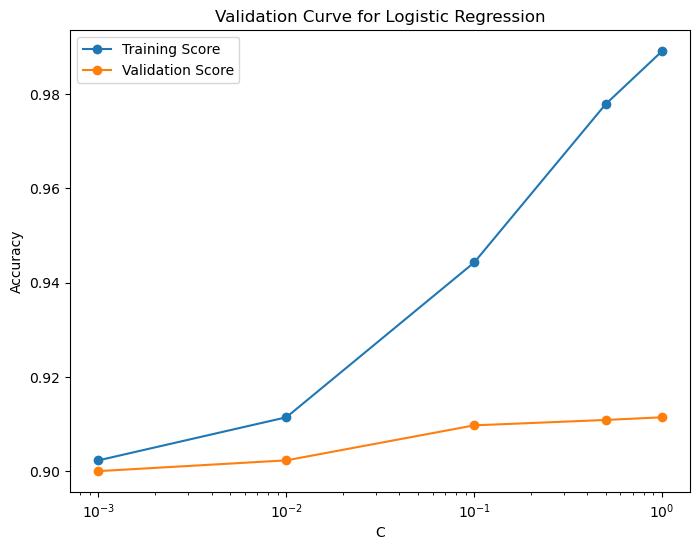

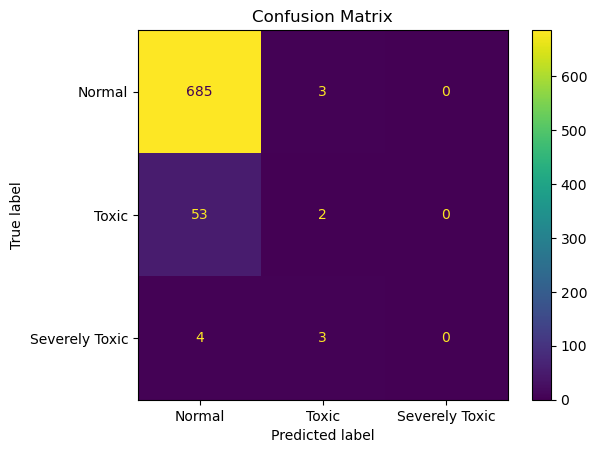

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

model = LogisticRegression(random_state=2024, multi_class='multinomial', max_iter=100000)
C_values = [0.001, 0.01, 0.1, 0.5, 1]
training_scores, validation_scores = validation_curve(
    model, X_train, y_train, param_name="C", param_range=C_values, cv=5, scoring="accuracy")

plt.figure(figsize=(8, 6))
plt.plot(C_values, np.mean(training_scores, axis=1), label="Training Score", marker='o')
plt.plot(C_values, np.mean(validation_scores, axis=1), label="Validation Score", marker='o')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Validation Curve for Logistic Regression")
plt.legend()
plt.show()

# I chose best C AFTER looking at the validation curve, as justified below
best_C = .01 
best_model = LogisticRegression(C=best_C, multi_class='multinomial', max_iter=1000, random_state=2024)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Toxic", "Severely Toxic"]).plot()
plt.title('Confusion Matrix')
plt.show()

According to the validation curve 10^-2 seems to be the best value of C, as it has high training accuracy (91%) with a very small generalization gap (~1%). A similar case could be made for C = 10^-3 because the values are quite similar, but the generalization gap clearly increases (more than we'd like) beyond C = 10^-2. 

## Task 3

Carefully inspect the confusion matrix of your final model from task 2. You should observe that, while the overall accuracy is reasonably high (likely above 90%), the accuracy is worst on comments that are severely toxic! You should also note that there are far fewer of these kinds of examples compared to normal comments. This phenomenon is called *data imbalance*.

For this task, experiment each of the following methods for addressing data imbalance:
1. *Resampling*: Rather than the original train set, create a new train set that has a roughly equal number of normal, toxic, and severely toxic comments. You can do so by *upsampling* -- adding additional examples of random toxic and severely toxic comments by repeating the examples you have in the training data, or by *downsampling* -- choosing only a subset of your normal and toxic examples to create a balanced training data set. You can write the code yourself from scratch (in which case you might find the [NumPy Random package](https://numpy.org/doc/stable/reference/random/index.html) helpful) or use the scikitlearn [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) functionality. You should not resample your test set; leave it unbalanced and representative of the original predictive task.
2. *Class reweighting*: Alternatively, you can leave the dataset alone but reweight the loss assosciated with errors on different classes for the model optimization. This is supported for [logistic regression in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) through the `class_weight` parameter. By default, the parameter is set to `None`, but setting it to `balanced` will result in optimization weights being set in inverse proportion to the frequency of the label (that is, less common classes like severely toxic are weighted more highly during the optimization of the logistic regression model).

Provide your implementations and report your results for each by computing and visualizing the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) on the test set. Use the same regularization parameter as in task 3. Select one of the results as your final model and briefly explain why you would select that, referencing the confusion matrices (and other metrics if you wish to compute them) and interpreting them in the context of the task to provide evidence for your choice.

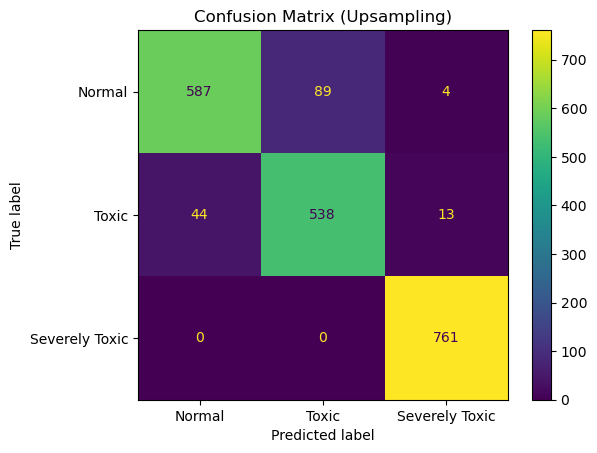

Precision (Normal): 0.93026941362916
Precision (Toxic): 0.8580542264752791
Precision (Severely Toxic): 0.9781491002570694
Recall (Normal): 0.8632352941176471
Recall (Toxic): 0.9042016806722689
Recall (Severely Toxic): 1.0


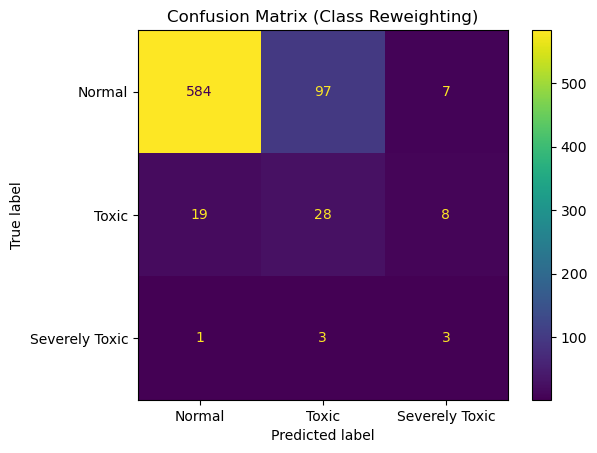

Precision (Normal): 0.9668874172185431
Precision (Toxic): 0.21875
Precision (Severely Toxic): 0.16666666666666666
Recall (Normal): 0.8488372093023255
Recall (Toxic): 0.509090909090909
Recall (Severely Toxic): 0.42857142857142855


In [14]:
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score

#Upsampling part
normal = df_sampled[df_sampled["toxic"] == 0]
toxic = df_sampled[df_sampled["toxic"] == 1]
severe_toxic = df_sampled[df_sampled["severe_toxic"] == 1]

toxic_upsampled = resample(toxic, replace=True, n_samples=len(normal), random_state=2024)
severe_toxic_upsampled = resample(severe_toxic, replace=True, n_samples=len(normal), random_state=2024)
df_upsampled = pd.concat([normal, toxic_upsampled, severe_toxic_upsampled])
X_upsampled = vectorizer.fit_transform(df_upsampled["comment_text"]).toarray()
y_upsampled = np.where(df_upsampled["severe_toxic"] == 1, 2, np.where(df_upsampled["toxic"] == 1, 1, 0))
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(X_upsampled, y_upsampled, test_size=0.3, random_state=2024)

best_model.fit(X_train_upsampled, y_train_upsampled)
y_pred_upsampled = best_model.predict(X_test_upsampled)

cm_upsampled = confusion_matrix(y_test_upsampled, y_pred_upsampled)
cm_upsampled_display = ConfusionMatrixDisplay(cm_upsampled, display_labels=["Normal", "Toxic", "Severely Toxic"]).plot()
plt.title('Confusion Matrix (Upsampling)')
plt.show()

print(f"Precision (Normal): {precision_score(y_test_upsampled, y_pred_upsampled, labels=[0], average='macro')}")
print(f"Precision (Toxic): {precision_score(y_test_upsampled, y_pred_upsampled, labels=[1], average='macro')}")
print(f"Precision (Severely Toxic): {precision_score(y_test_upsampled, y_pred_upsampled, labels=[2], average='macro')}")
print(f"Recall (Normal): {recall_score(y_test_upsampled, y_pred_upsampled, labels=[0], average='micro')}")
print(f"Recall (Toxic): {recall_score(y_test_upsampled, y_pred_upsampled, labels=[1], average='micro')}")
print(f"Recall (Severely Toxic): {recall_score(y_test_upsampled, y_pred_upsampled, labels=[2], average='micro')}")

#Class reweighting part
best_model_reweighted = LogisticRegression(C=best_C, multi_class='multinomial', max_iter=1000, random_state=2024, class_weight="balanced")
best_model_reweighted.fit(X_train, y_train)
y_pred_reweighted = best_model_reweighted.predict(X_test)

cm_reweighted = confusion_matrix(y_test, y_pred_reweighted)
cm_display_reweighted = ConfusionMatrixDisplay(cm_reweighted, display_labels=["Normal", "Toxic", "Severely Toxic"]).plot()
plt.title('Confusion Matrix (Class Reweighting)')
plt.show()

print(f"Precision (Normal): {precision_score(y_test, y_pred_reweighted, labels=[0], average='macro')}")
print(f"Precision (Toxic): {precision_score(y_test, y_pred_reweighted, labels=[1], average='macro')}")
print(f"Precision (Severely Toxic): {precision_score(y_test, y_pred_reweighted, labels=[2], average='macro')}")
print(f"Recall (Normal): {recall_score(y_test, y_pred_reweighted, labels=[0], average='macro')}")
print(f"Recall (Toxic): {recall_score(y_test, y_pred_reweighted, labels=[1], average='macro')}")
print(f"Recall (Severely Toxic): {recall_score(y_test, y_pred_reweighted, labels=[2], average='macro')}")

Clearly, the class reweighting model performs worse on about all metrics of recall and precision. In a model like we are trying to construct, it is important to be able to identify the most severe comments with the highest precision and recall. Yes, the second model may have higher precision for identifying normal comments but that is because there are so many of them; likewise it is terrible at identifying severely toxic comments. For that reason I will choose the upsampled model. (also, I upsampled instead of downsampled because I had already shrunk the dataset so much to prevent my kernel from dying)

## Task 4

Identify the top 50 words in the vocabulary most strongly assosciated with toxicity by the model by inspecting the model coefficients (the `.coef_` attribute of the trained model). Using these findings, discuss some of the limitations of the BOW model for this task, explaining in particular why you would expect some false positives of normal texts incorrectly identified as toxic.

In [15]:
toxic_coef = best_model.coef_[0] 
feature_names = vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': toxic_coef})

coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)
top_50_words = coef_df.head(50)
print(top_50_words)

           word  coefficient
877        fuck    -0.601545
1966       shit    -0.350422
928          go    -0.332121
851         for     0.299964
918         get    -0.292723
2097     stupid    -0.286450
882     fucking    -0.269481
134         are    -0.243297
908         gay    -0.238350
1517        off    -0.234825
2139       talk     0.230826
168          at     0.224484
2087       stop    -0.224157
158         ass    -0.218670
2210         to     0.213083
161     asshole    -0.212315
2106       suck    -0.204348
2490       your    -0.204180
1412     mother    -0.201723
2413        why    -0.187274
417        cock    -0.180951
607         die    -0.180173
77          all    -0.175564
1491        not     0.174473
217          be     0.170755
148     article     0.170089
1431         my    -0.170047
2009       slut    -0.162711
273       block    -0.161744
1114        ing    -0.153479
1320     making    -0.151486
1037       hope    -0.149344
2286         up    -0.148868
2169        th

Many of these make sense - they are just curse words. However, there are many extremely common words in here, which suggests that you might get some false positives for toxic text. To fix this, it'd be wise to decrease the parameter max_df. 

# Task 5

Machine learning continues to be applied for content moderation to detect and remove hate speech. For example, read [Meta's discussion](https://ai.meta.com/blog/ai-advances-to-better-detect-hate-speech/) of AI hate speech detection advances at the company. There is an obvious advantage to automated machine learning models to deal with the scale of data on modern social media platforms. Others are skeptical about relying on machine learning models for this purpose. For example, also read [A Brave New World of Mediated Online Discourse](https://cacm.acm.org/opinion/a-brave-new-world-of-mediated-online-discourse/), a 2022 opinion piece in the Communications of the ACM (the leading computer science professional society).

In 2-3 paragraphs, take a position on the question "Should machine learning models be used to automatically detect and/or remove toxic speech from social media platforms?" Briefly substantiate your position referencing the above articles or other sources of your own choosing.

There is much evidence in favor of using machine learning models to automatically filter hate/toxic speech from social media plastforms. According to Meta's article, beyond saving time and effort that would normally be done by humans, AI can proactively remove harmful content - even before users report it. Such models are a necessity for large platforms like Facebook, Instagram etc. because of how well they can scale to ast amounts of user-generated content (from ACM article). Furthermore, AI hate speech detection technolpgy has only been improving and will continue to develop a more holistic view of the content it moderates. Clearly, there is economic benefit and lots of upside. 
As denoted in both articles, there are downsides to AI content moderation. Meta says that there are ways for malicious actors to maniupulate and exploit the system by creating new words, using different speech patterns, etc. The ACM article describes several more downsides, including over-censorship (due to a large number of false positives, as we saw in the model from part 5). These algorithms are imperfect, as they are only as complex as their training data. It can be hard to interpret sentiment and social cues as well. Finally, it can be seen as concerning that the demarcation of what is "toxic" is not democratic, but instead left up to a small group of people or even just the computer. 
As I frequently find myself doing, I am going to break the binary nature of the question and posit: "why can't we do both?" I think that the power and potential of AI content filtration are undeniable. It can do what humans cannot (and should not have to) do, especially with such large sums of data. But I think it's only right that humans be involved with the process one way or another. I like to think that the human and the AI should agree, and if they don't then the problem should be investigated further. Humans can keep AI in check and provide insight (especially sentimental, notably human insight) to it. There is no AI without humans, but in the future there may be no humans without AI - so the two must work together. 